# RSVQAxBEN Database creation

## Conversion of S2 images to uint8 RGB
S2 images feature 12 bands encoded as 12 bits integers (so in uint16). For this project, to keep it more managable, we select the RGB bands only, and convert them to uint8.

The first step is to indicate the location of the original BigEarthNet dataset (BEN_folder), and where you want to store the converted images (Out_folder)

In [1]:
BEN_folder = r'' #TO FILL
Out_folder = r'G:\BN_VQA\StackedImages_b' #TO FILL

We can now do the conversion using rasterio. Careful, this will take a long time!

In [3]:
import os
import shutil
from tqdm import tqdm
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

for image_name in tqdm(os.listdir(BEN_folder)):
  image_folder = os.path.join(BEN_folder, image_name)
  metadata_file = os.path.join(image_folder, image_name) + '_labels_metadata.json'

  file_list = []
  for i in [4,3,2]:
    file_list.append(os.path.join(image_folder, image_name) + '_B0' + str(i) + '.tif')
  
  with rasterio.open(file_list[0]) as src:
    meta = src.meta
    meta.update(count = 3)
    meta.update(dtype = 'uint8')

  # Read each layer and write it to stack
  with rasterio.open(os.path.join(Out_folder, image_name) + '.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src:
          tmp = src.read(1) / 4096 * 255 #(4096 = 2**12)
          reproject(
                    source=tmp,
                    destination=rasterio.band(dst, id),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=src.transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest)
  shutil.copy(metadata_file, Out_folder)


FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [6]:
CLC_hierarchy = {'artificial areas':
                 {'urban fabric':['continuous urban fabric', 'discontinuous urban fabric'],
                  'industrial, commercial, and transport units':['industrial or commercial units', 'road and rail networks and associated land', 'port areas', 'airports'],
                  'mine, dump and construction sites':['mineral extraction sites', 'dump sites', 'construction sites'],
                  'artificial non-agricultural vegetated areas':['green urban areas', 'sport and leisure facilities']
                  },
                 'agricultural areas':
                 {'arable land':['non-irrigated arable land', 'permanently irrigated land', 'rice fields'],
                  'permanent crops':['vineyards', 'fruit trees and berry plantations', 'olive groves'],
                  'pastures':['pastures'],
                  'heterogeneous agricultural areas':['annual crops associated with permanent crops', 'complex cultivation patterns', 'land principally occupied by agriculture, with significant areas of natural vegetation', 'agro-forestry areas']
                  },
                 'forest and seminatural areas':
                 {'forests':['broad-leaved forest', 'coniferous forest', 'mixed forest'],
                  'scrub and/or herbaceous vegetation associations':['natural grassland', 'moors and heathland', 'sclerophyllous vegetation', 'transitional woodland/shrub'],
                  'open spaces with little or no vegetation':['beaches, dunes, sands', 'bare rock', 'sparsely vegetated areas', 'burnt areas']#, 'glaciers and perpetual snow']
                  },
                 'wetlands':
                 {'inland wetlands':['inland marshes', 'peatbogs'],
                  'maritime wetlands':['salt marshes', 'salines', 'intertidal flats']
                  },
                 'water bodies':
                 {'inland waters':['water courses', 'water bodies'],
                  'marine waters':['coastal lagoons', 'estuaries', 'sea and ocean']
                  }
                }


CLC_dict = {'mixed forest':['mixed forest', 'forest'],
            'coniferous forest':['coniferous forest', 'forest'],
       'non-irrigated arable land':['non-irrigated arable area', 'arable area', 'agricultural area'],
       'transitional woodland/shrub':['woodland', 'shrub', 'scrub'],
       'broad-leaved forest':['broad-leaved forest', 'forest'],
       'land principally occupied by agriculture, with significant areas of natural vegetation':['agricultural area'],
       'complex cultivation patterns':['agricultural area'],
       'pastures':['pastures'],
       'water bodies':['water body', 'water area', 'inland water', 'water'],
       'sea and ocean':['sea', 'ocean', 'marine water', 'water'],
       'discontinuous urban fabric':['discontinuous urban fabric', 'urban fabric', 'artificial area'],
       'agro-forestry areas':['agro-forestry area', 'agricultural area'],
       'peatbogs':['peat bog', 'inland wetland', 'wetland'],
       'permanently irrigated land':['permanently irrigated area', 'arable area', 'agricultural area'],
       'industrial or commercial units':['industrial area', 'commercial area', 'artificial area'],
       'natural grassland':['natural grassland', 'grassland', 'scrub'],
       'olive groves':['olive groves', 'permanent crop', 'agricultural area'],
       'sclerophyllous vegetation':['sclerophyllous vegetation', 'vegetation', 'scrub'],
       'continuous urban fabric':['continuous urban fabric', 'urban fabric', 'artificial area'],
       'water courses':['water courses', 'inland water', 'water'],
       'vineyards':['vineyards', 'permanent crops', 'agricultural area'],
       'annual crops associated with permanent crops':['annual crops', 'agricultural area'],
       'inland marshes':['inland marshes', 'inland wetland', 'wetland'],
       'moors and heathland':['moors', 'heathland', 'scrub'],
       'sport and leisure facilities':['leisure facilities', 'artificial area'],
       'fruit trees and berry plantations':['orchard', 'permanent crop', 'agricultural area'],
       'mineral extraction sites':['mine', 'artificial area'],
       'rice fields':['rice fields', 'arable area', 'agricultural area'],
       'road and rail networks and associated land':['road', 'railway', 'transport unit', 'artificial area'],
       'bare rock':['rock'],
       'green urban areas':['green urban area', 'artificial vegetated area', 'artificial area'],
       'beaches, dunes, sands':['beach'],
       'sparsely vegetated areas':['sparsely vegetated area'],
       'salt marshes':['salt marshes', 'maritime wetland', 'wetland'],
       'coastal lagoons':['lagoon', 'marine water', 'water'],
       'construction sites':['construction site','artificial area'],
       'estuaries':['estuary', 'marine water', 'water'],
       'intertidal flats':['tidal', 'maritime wetland', 'wetland'],
       'airports':['airport', 'transport unit', 'artificial area'],
       'dump sites':['dump', 'artificial area'],
       'port areas':['port', 'artificial area'],
       'salines':['salt pond', 'maritime wetland', 'wetland'],
       'burnt areas':['burnt area']}

In [7]:
for L1 in CLC_hierarchy:
  print(f"- L1 class: {L1}")
  for L2 in CLC_hierarchy[L1]:
    print(f"-- L2 class: {L2}")
    for L3 in CLC_hierarchy[L1][L2]:
      print(f"--- L3 class: {L3}: {CLC_dict[L3]}")

- L1 class: artificial areas
-- L2 class: urban fabric
--- L3 class: continuous urban fabric: ['continuous urban fabric', 'urban fabric', 'artificial area']
--- L3 class: discontinuous urban fabric: ['discontinuous urban fabric', 'urban fabric', 'artificial area']
-- L2 class: industrial, commercial, and transport units
--- L3 class: industrial or commercial units: ['industrial area', 'commercial area', 'artificial area']
--- L3 class: road and rail networks and associated land: ['road', 'railway', 'transport unit', 'artificial area']
--- L3 class: port areas: ['port', 'artificial area']
--- L3 class: airports: ['airport', 'transport unit', 'artificial area']
-- L2 class: mine, dump and construction sites
--- L3 class: mineral extraction sites: ['mine', 'artificial area']
--- L3 class: dump sites: ['dump', 'artificial area']
--- L3 class: construction sites: ['construction site', 'artificial area']
-- L2 class: artificial non-agricultural vegetated areas
--- L3 class: green urban areas

In [9]:
import random

def get_labels(CLC_labels):
  roots = CLC_hierarchy.keys()

  L1_present = []
  L1_absent = []
  L2_present = []
  L2_absent = []
  L3_present = []
  L3_absent = []

  for L1 in roots:
    L1_present_b = False
    for L2 in CLC_hierarchy[L1].keys():
      L2_present_b = False
      for L3 in CLC_hierarchy[L1][L2]:
        if L3 in CLC_labels:
          L3_present.append((L1, L2, L3))
          L2_present_b = True
          L1_present_b = True
        else:
          L3_absent.append([L1, L2, L3])
      if L2_present_b:
        L2_present.append([L1, L2])
      else:
        L2_absent.append([L1, L2])
    if L1_present_b:
      L1_present.append([L1])
    else:
      L1_absent.append([L1])

  output = {"L1":{"present":L1_present, "absent":L1_absent}, "L2":{"present":L2_present, "absent":L2_absent}, "L3":{"present":L3_present, "absent":L3_absent}}

  return output

def generate_yes_no_question(labels):
  #Choose CLC hierarchical level for the question
  question_level = random.choice(["L1","L2","L3"])
  labels_present = labels[question_level]["present"]
  labels_absent = labels[question_level]["absent"]
  question = None

  #Choose the answer to the question
  dice = random.random()
  if dice < 0.5:
    answer = "yes"
  else:
    answer = "no"

  if answer == "no":
    dice = random.random()
    if dice < 0.5:
      if len(labels_absent) >= 1:
        LC = random.choice(labels_absent)[-1]
        question = ("presence", "logical 1", "#", [LC], "no")
    elif dice < 0.65:
      if len(labels_absent) >= 1 and len(labels_present) >= 1:
        LCs = [random.choice(labels_absent)[-1], random.choice(labels_present)[-1]]
        random.shuffle(LCs)
        question = ("presence", "logical 2", "# and #", LCs, "no")
    elif dice < 0.725:
      if len(labels_absent) >= 2:
        random.shuffle(labels_absent)
        LCs = [labels_absent[0][-1], labels_absent[1][-1]]  
        random.shuffle(LCs)
        question = ("presence", "logical 2", "# and #", LCs, "no")
    elif dice < 0.8:
      if len(labels_absent) >= 2:
        random.shuffle(labels_absent)
        LCs = [labels_absent[0][-1], labels_absent[1][-1]]
        question = ("presence", "logical 2", "# or #", LCs, "no")
    else:
      if len(labels_absent) >= 2 and len(labels_present) >= 1:
        random.shuffle(labels_absent)
        neg = [labels_absent[0][-1], labels_absent[1][-1]]
        pos = random.choice(labels_present)[-1]
        dice2 = random.random()
        if dice2 < 0.5:
          LCs = neg + [pos]
          question = ("presence", "logical 3", "# or # and #", LCs, "no")
        else:
          LCs = [pos] + neg
          question = ("presence", "logical 3", "# and # or #", LCs, "no")



  if answer == "yes":
    #Choose the number of positive samples
    dice = random.random()
    if dice < 0.5:
      if len(labels_present) >= 1:
        LC = random.choice(labels_present)[-1]
        question = ("presence", "logical 1", "#", [LC], "yes")
    elif dice < 0.65:
      if len(labels_present) >= 2:
        random.shuffle(labels_present)
        LCs = [labels_present[0][-1], labels_present[1][-1]]
        question = ("presence", "logical 2", "# and #", LCs, "yes")
    elif dice < 0.8:
      if len(labels_present) >= 1 and len(labels_absent) >= 1:
        LCs = [random.choice(labels_present)[-1], random.choice(labels_absent)[-1]]
        random.shuffle(LCs)
        question = ("presence", "logical 2", "# or #", LCs, "yes")
    else:
      if len(labels_present) >= 2 and len(labels_absent) >= 1:
        random.shuffle(labels_present)
        LC1 = labels_present[0][-1]
        LC2 = labels_present[1][-1]
        LC3 = random.choice(labels_absent)[-1]
        dice2 = random.random()
        pos = [LC1, LC2]
        random.shuffle(pos)
        if dice2 < .25:
          LCs = pos + [LC3]
          question = ("presence", "logical 3", "# and # or #", LCs, "yes")
        elif dice2 < .5:
          LCs = [LC3] + pos
          question = ("presence", "logical 3", "# or # and #", LCs, "yes")
        elif dice2 < .75:
          LCs = pos + [LC3]
          question = ("presence", "logical 3", "# or # and #", LCs, "yes")
        else:
          LCs = [pos[0], LC3, pos[1]]
          question = ("presence", "logical 3", "# and # or #", LCs, "yes")
  
  #Check that there is no LC containing "and"
  if question:
    for LC in question[3]:
      if "and/or" in LC or " or " in LC or " and " in LC:
        question = None
  return question


def generate_LC_question(labels):
  question = None
  question_level = random.choices(["L1", "L2", "L3", "L1L2L3"], cum_weights=[40, 50, 90, 100])[0]
  if question_level != "L1L2L3":
    labels_present = labels[question_level]["present"]
    
    dice = random.random()
    if dice < 0.75:
      LCs = []
      for label in labels_present:
        LCs += [label[-1]]
      question = ("LC", "type 1", question_level, sorted(LCs))
    elif dice < 0.9:
      if len(labels_present) >= 1:
        LCs = []
        LC1 = random.choice(labels_present)[-1]
        for label in labels_present:
          if label[-1] != LC1:
            LCs += [label[-1]]
        question = ("LC", "type 2", question_level, [LC1] + sorted(LCs))
    else:
      if len(labels_present) >= 2:
        LCs = []
        random.shuffle(labels_present)
        LC1 = labels_present[0][-1]
        LC2 = labels_present[1][-1]
        for label in labels_present:
          if label[-1] != LC1 and label[-1] != LC2:
            LCs += [label[-1]]
        question = ("LC", "type 3", question_level, [LC1, LC2] + sorted(LCs))

  else:
    labels_present = []
    for lvl in ["L1", "L2", "L3"]:
      for label in labels[lvl]["present"]:
        if label[-1] not in labels_present:
          labels_present += [label[-1]]
    question = ("LC", "type 1", question_level, labels_present)
  #Check that there is no label with "and"
  if question:
    for label in question[3]:
      if "and/or" in label or " or " in label or " and " in label:
        question = None
  return question
  

def get_text_representation_of_question(question):
  outputq = ""
  outputa = ""
  if question[0] == "presence":
    outputa = question[4]
    if question[1] == "logical 1":
      outputq = random.choice(["Are there some #", "Are some # present"])
      outputq = outputq.replace("#", question[3][0])
    elif question[1] == "logical 2":
      outputq = random.choice(["Are there #", "Are # present"])
      outputq = outputq.replace("#", question[2])
      outputq = outputq.replace("#", question[3][0], 1)
      outputq = outputq.replace("#", question[3][1])
    elif question[1] == "logical 3":
      outputq = random.choice(["Are there #", "Are # present"])
      outputq = outputq.replace("#", question[2])
      for i in range(3):
        outputq = outputq.replace("#", question[3][i], 1)
    dice = random.random()
    if dice < .25:
      outputq += " in the image?"
    elif dice < .5:
      outputq += " in the scene?"
    else:
      outputq += "?"
  else:
    answer_LCs = []
    if question[1] == "type 1":
      answer_LCs = question[3]
      if question[2] != "L1L2L3":
        outputq = random.choice(["What " + question[2] + " land cover classes are there", "Which " + question[2] + " land cover classes are", "Which " + question[2] + " classes are"])
      else:
        outputq = random.choice(["What are all the land cover classes", "Which land cover classes are"])
    elif question[1] == "type 2":
      outputq = random.choice(["Besides #, what land cover classes are", "In addition to #, what are the land cover classes", "In addition to #, which classes are", "Besides #, which classes are"])
      outputq = outputq.replace("#", question[3][0])
      answer_LCs = question[3][1:]
    else:
      outputq = random.choice(["Besides # and #, what land cover classes are", "Besides # and #, what classes are", "In addition to # and #, what are the land cover classes", "In addition to # and #, what classes are"])
      outputq = outputq.replace("#", question[3][0], 1)
      outputq = outputq.replace("#", question[3][1], 1)
      answer_LCs = question[3][2:]
    if len(answer_LCs) == 0:
      outputa = "None"
    elif len(answer_LCs) == 1:
      outputa = answer_LCs[0]
    else:
      outputa = answer_LCs[0]
      for i in range(1, len(answer_LCs) - 1):
        outputa += ", " + answer_LCs[i]
      outputa += " and " + answer_LCs[-1]
    dice = random.random()
    if dice < .5:
      outputq += " in the image?"
    else:
      outputq += " in the scene?"
  
  return outputq, outputa


def ask_questions(CLC_labels, number=10, tries=1000):
  generic_questions = []
  questions = []
  answers = []
  labels = get_labels([label.lower() for label in CLC_labels])
  while number and tries:
    tries -= 1
    #choose answer type:
    dice = random.random()

    if dice < 0.5:
      question_type = "yes/no"
      question = generate_yes_no_question(labels)
    else:
      question_type = "LC"
      question = generate_LC_question(labels)
    
    if question and question not in generic_questions:
      generic_questions.append(question)
      txt_question, txt_answer = get_text_representation_of_question(question)
      questions.append(txt_question)
      answers.append(txt_answer)
      number-=1

  return questions, answers, generic_questions

ask_questions(['Coniferous forest', 'Mixed forest', 'Sea and ocean'], number=25)

(['Which L2 land cover classes are in the image?',
  'Are some wetlands present in the image?',
  'Are there some sparsely vegetated areas?',
  'Are salines or peatbogs present?',
  'Are there coniferous forest and intertidal flats in the scene?',
  'Are there some artificial areas in the scene?',
  'Are there agricultural areas or artificial areas?',
  'Are there some marine waters?',
  'Are some coniferous forest present?',
  'Are forests and marine waters or maritime wetlands present?',
  'Are forests or marine waters and inland wetlands present in the scene?',
  'Are there some forests?',
  'Are coniferous forest or non-irrigated arable land present?',
  'Are there some heterogeneous agricultural areas in the image?',
  'Are there some port areas in the image?',
  'Are there inland waters or marine waters and forests?',
  'Are there forests and inland waters or inland wetlands in the scene?',
  'Are there some agricultural areas?',
  'Are some water bodies present in the image?',
 

In [5]:
import os
import json
import DatabaseIO as db
from tqdm.notebook import tqdm
import random

random.seed(42)

if db.get_id_from_key("people", "login", "AutoDB") == []:
  db.add_people("AutoDB", "", "Automatic DB creation", "")

image_list = [f for f in os.listdir(Out_folder) if f.startswith('S2') and f.endswith('.tif')]
print(len(image_list), flush=True)
for i, image_name in enumerate(tqdm(image_list)):
  image_path = os.path.join(Out_folder, image_name)
  if db.get_id_from_key("images", "original_name", image_path) == []:
    metadata_path = os.path.join(Out_folder, image_name)[:-4] + '_labels_metadata.json'
    metadata = json.load(open(metadata_path, 'r'))
    CLC_labels = metadata['labels']
    questions, answers, g_questions = ask_questions(CLC_labels, number=25)

    img_id = db.add_image(image_path, 'S2', metadata["coordinates"]["ulx"], metadata["coordinates"]["uly"], "10m", "10m", 0, "RGB")
    for qid in range(len(questions)):
      question_id = db.add_question(img_id, 0, g_questions[qid][0], questions[qid])
      db.add_answer(question_id, 0, answers[qid])

db.write_to_db()

590326


## Dataset splitting
We want to split the dataset in train/validation/test sets, based on their coordinate.

First, we are going to construct an histogram of the coordinates' distribution.

Reading images to exclude (seasonal snow, cloud and shadow)
Excluding 70987 patches from the db
Reading database of images...
Done.
Computing the distribution of the coordinates...



Done


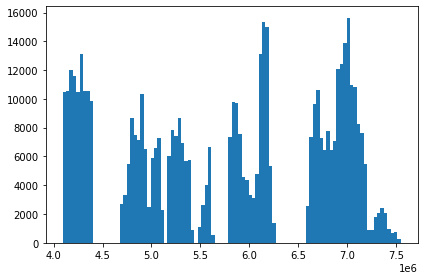

In [2]:
import DatabaseIO as db
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt
import numpy as np

#Read CSV of images to exclude:
print("Reading images to exclude (seasonal snow, cloud and shadow)", flush=True)
images_to_exclude = []
for filename in ['patches_with_seasonal_snow.csv', 'patches_with_cloud_and_shadow.csv']:
    with open(filename) as csvfile:
        to_exclude_reader = csv.reader(csvfile)
        for row in to_exclude_reader:
            images_to_exclude.append(row[0]+'.tif')
print(f"Excluding {len(images_to_exclude)} patches from the db")

discriminating_coordinate = "upperleft_map_y" #Coordinate on which to separate the db in train/val/test
#Choose from upperleft_map_y and upperleft_map_x

print("Reading database of images...", flush=True)
db_images = db.get_db("images")
print("Done.", flush=True)
#Compute the distribution
print("Computing the distribution of the coordinates...", flush=True)
coordinates = []
for image_index in tqdm(range(len(db_images))):
    entry = db_images[image_index]
    if entry['original_name'] not in images_to_exclude:
        coordinates.append(entry[discriminating_coordinate])
print("Done")

coordinates.sort()

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(coordinates, bins=100)
plt.show()

In [3]:
from tqdm import tqdm
import DatabaseIO as db

db_q = db.get_db("questions")

count_and_or = 0
count_and = 0
count_or = 0

for i in tqdm(range(len(db_q))):
    if "and" in db_q[i]["question"] and "or" in db_q[i]["question"]:
        count_and_or += 1
    else:
        if "and" in db_q[i]["question"]:
            count_and += 1
        else:
            if "or" in db_q[i]["question"]:
                count_or += 1
                
print(f"Number of and/or: {count_and_or}")
print(f"Number of and: {count_and}")
print(f"Number of or: {count_or}")


100%|██████████| 14758150/14758150 [00:24<00:00, 594996.27it/s] 


Number of and/or: 4004615
Number of and: 4741869
Number of or: 1927650


In [ ]:
from tqdm import tqdm
import DatabaseIO as db

db_q = None
#db_a = db.get_db("answers")


count_yes = 0
count_no = 0
count_none = 0
count_lc = 0

answers_diff = set()
answers_dict = {}
for i in tqdm(range(len(db_a))):
    if db_a[i]['answer'] == "yes":
        count_yes += 1
    else:
        if db_a[i]['answer'] == "no":
            count_no += 1
        else:
            if db_a[i]['answer'] == "None":
                count_none += 1
            else:
                count_lc += 1
    answers_diff.add(db_a[i]['answer'])
    if db_a[i]['answer'] in answers_dict:
        answers_dict[db_a[i]['answer']] += 1
    else:
        answers_dict[db_a[i]['answer']] = 1
 
print(len(db_a))
print(f"Number of yes: {count_yes}")
print(f"Number of no: {count_no}")
print(f"Number of none: {count_none}")
print(f"Number of lc: {count_lc}")
print(f"Number of different answers: {len(answers_diff)}")


sort_answers = sorted(answers_dict.items(), key=lambda x: x[1], reverse=True)
print(sort_answers[:20])


    

In [ ]:
count = 0
for ans in sort_answers:
    if ans[1] == 1:
        count += 1
        if count == 1:
            print(ans[0])
        
print(count)

In [5]:
for i in range(10000):
    if db_q[i]['type'] == 'presence':
        print(db_q[i]['question'])

100%|██████████| 14758150/14758150 [00:16<00:00, 898369.51it/s]

14758150
Number of yes: 4591079
Number of no: 7320314
Number of none: 418265
Number of lc: 2428492
Number of different answers: 28051
[('no', 7320314), ('yes', 4591079), ('None', 418265), ('water bodies', 101456), ('agricultural areas', 78239), ('marine waters', 70334), ('coniferous forest', 64492), ('coniferous forest and mixed forest', 53930), ('forests', 53081), ('mixed forest', 52006), ('non-irrigated arable land', 49189), ('transitional woodland/shrub', 44664), ('pastures', 37610), ('broad-leaved forest', 35192), ('coniferous forest and transitional woodland/shrub', 34013), ('coniferous forest, mixed forest and transitional woodland/shrub', 33992), ('forests and inland waters', 29104), ('forests and heterogeneous agricultural areas', 28119), ('arable land', 27801), ('agricultural areas and artificial areas', 27522)]


In [10]:
count = 0
for ans in sort_answers:
    if ans[1] == 1:
        count += 1
        if count == 1:
            print(ans[0])
        
print(count)

broad-leaved forest, complex cultivation patterns, coniferous forest, discontinuous urban fabric, land principally occupied by agriculture, with significant areas of natural vegetation, mixed forest, non-irrigated arable land and water courses
12218


In [ ]:
for i in range(10000):
    if db_q[i]['type'] == 'presence':
        print(db_q[i]['question'])

In [1]:
The second step is to choose the boundaries for the different datasets:

{'id': 0, 'date_added': 1607956241.3731923, 'img_id': 0, 'people_id': 0, 'type': 'LC', 'question': 'What L1 land cover classes are there in the image?', 'answers_ids': [0], 'active': True}


In [8]:
for i in range(10000):
    if db_q[i]['type'] == 'presence':
        print(db_q[i]['question'])

Are there some sclerophyllous vegetation in the image?
Are there some maritime wetlands?
Are there water bodies or artificial areas in the scene?
Are heterogeneous agricultural areas or artificial non-agricultural vegetated areas present?
Are there some marine waters?
Are some estuaries present in the scene?
Are some artificial areas present in the scene?
Are there some burnt areas?
Are some inland marshes present in the image?
Are there water bodies and agricultural areas or wetlands?
Are water bodies and artificial areas present?
Are some water bodies present in the image?
Are water bodies and agricultural areas or artificial areas present?
Are arable land or permanent crops and marine waters present in the scene?
Are some wetlands present?
Are some agricultural areas present in the scene?
Are port areas and mixed forest present in the scene?
Are there water bodies and agricultural areas in the scene?
Are there agricultural areas and artificial areas?
Are there wetlands or artificial

Are there some salines?
Are there maritime wetlands and marine waters in the image?
Are wetlands or artificial areas present?
Are there some agro-forestry areas?
Are some mineral extraction sites present in the image?
Are urban fabric and marine waters present?
Are there agricultural areas or artificial areas and water bodies?
Are some maritime wetlands present in the image?
Are wetlands and water bodies present?
Are there water bodies and wetlands or artificial areas in the scene?
Are natural grassland and continuous urban fabric present?
Are some land principally occupied by agriculture, with significant areas of natural vegetation present?
Are some permanent crops present in the scene?
Are there some mixed forest in the scene?
Are some pastures present in the image?
Are wetlands or water bodies present in the image?
Are some bare rock present in the image?
Are some inland wetlands present?
Are there some vineyards in the scene?
Are there some mineral extraction sites?
Are there arab

Are there some inland waters?
Are there some agro-forestry areas in the scene?
Are there some wetlands?
Are water bodies or agricultural areas and wetlands present in the image?
Are there some land principally occupied by agriculture, with significant areas of natural vegetation?
Are some agricultural areas present?
Are some water bodies present in the scene?
Are there salt marshes and coniferous forest?
Are agricultural areas or wetlands present in the image?
Are there some inland wetlands in the image?
Are some non-irrigated arable land present?
Are there some rice fields in the scene?
Are some water bodies present in the image?
Are discontinuous urban fabric and coastal lagoons present?
Are there some forests?
Are some urban fabric present in the scene?
Are there rice fields or vineyards?
Are there coniferous forest and salines in the scene?
Are there discontinuous urban fabric and mixed forest in the scene?
Are there artificial non-agricultural vegetated areas or maritime wetlands 

Are some salines present?
Are water courses and pastures present?
Are some marine waters present in the image?
Are there arable land and heterogeneous agricultural areas in the scene?
Are there some water bodies in the scene?
Are inland waters or marine waters present?
Are there wetlands or artificial areas in the scene?
Are there some permanent crops?
Are there agricultural areas or artificial areas and water bodies in the scene?
Are agricultural areas and water bodies present in the scene?
Are some heterogeneous agricultural areas present?
Are water bodies or artificial areas present in the image?
Are there bare rock or burnt areas?
Are there some wetlands?
Are there water bodies and agricultural areas or artificial areas in the image?
Are there some artificial areas in the scene?
Are some maritime wetlands present in the scene?
Are some salt marshes present in the image?
Are there some rice fields?
Are some annual crops associated with permanent crops present in the image?
Are inlan

The second step is to choose the boundaries for the different datasets:

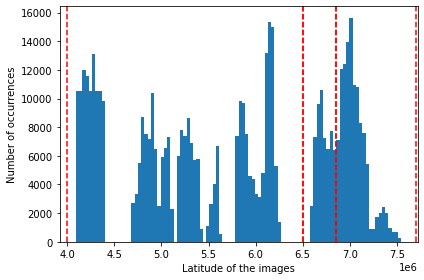

344385 selected for train set (66.3121775949813% of the valid dataset).
56829 selected for val set (10.94256352786908% of the valid dataset).
118125 selected for test set (22.745258877149606% of the valid dataset).


In [4]:
boundaries = {
    "train":{"start":4*10**6, "end":6.5*10**6},
    "val":{"start":6.5*10**6, "end":6.85*10**6},
    "test":{"start":6.85*10**6, "end":7.7*10**6},
}

coordinates_splits = {}
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(coordinates, bins=100)
axs.set_xlabel('Latitude of the images')
axs.set_ylabel('Number of occurrences')

for split in boundaries.keys():
    axs.axvline(x=boundaries[split]["start"], color='r', linestyle='--')
    axs.axvline(x=boundaries[split]["end"], color='r', linestyle='--')

plt.show()
fig.savefig('DatasetSplits.svg')

coordinates = np.array(coordinates)

for split in boundaries.keys():
    coordinates_splits[split] = coordinates[(coordinates > boundaries[split]["start"]) & (coordinates < boundaries[split]["end"])]
    print(f"{coordinates_splits[split].shape[0]} selected for {split} set ({coordinates_splits[split].shape[0]/coordinates.shape[0]*100}% of the valid dataset).")

In [8]:
import json

output_subdb_name = "RSVQAxBEN_split_{}_{}"

for split in coordinates_splits.keys():
    print(f"Creating {split} set.")
    print(f"Creating images db", flush=True)
    images = []
    number = 0
    db_images = db.get_db("images")
    for image_index in tqdm(range(len(db_images))):
        entry = db_images[image_index]
        coordinate = entry[discriminating_coordinate]
        if entry['original_name'] not in images_to_exclude and coordinate > boundaries[split]["start"] and coordinate < boundaries[split]["end"]:
            images.append(entry)
            number += 1
        else:
            images.append({'id': image_index, 'active': False})
    db_images = None #Free memory 
    print(f"Done creating image db. {number/len(images)*100}% of the db selected.")

    print(f"Creating questions db", flush=True)
    questions = []
    number = 0
    last_question_id = 0
    db_questions = db.get_db("questions")
    for image in tqdm(images):
        if image['active']:
            questions_ids = image["questions_ids"]
            while last_question_id < questions_ids[0]:
                questions.append({'id':last_question_id, 'active': False})
                last_question_id += 1
            for question_id in questions_ids:
                questions.append(db_questions[question_id])
                number += 1
            last_question_id = question_id + 1
    print(f"Done creating question db. {number/len(questions)*100}% of the db selected.")
    db_questions = None #free memory
    
    print(f"Creating answers db", flush=True)
    answers = []
    number = 0
    last_answer_id = 0
    db_answers = db.get_db("answers")
    for question in tqdm(questions):
        if question['active']:
            answers_ids = question["answers_ids"]
            while last_answer_id < answers_ids[0]:
                answers.append({'id':last_answer_id, 'active': False})
                last_answer_id += 1
            for answer_id in answers_ids:
                answers.append(db_answers[answer_id])
                number += 1
            last_answer_id = answer_id + 1
    print(f"Done creating answer db. {number/len(answers)*100}% of the db selected.")
    db_answers = None #free memory
    
    with open(output_subdb_name.format(split, "images")+".json", 'w') as fd:
        json.dump({"images": images}, fd)
    with open(output_subdb_name.format(split, "images")+".js", 'w') as fd:
        fd.write('var imagesBEN = JSON.parse(\'')
        json.dump({"images": images}, fd)
        fd.write('\');')
        
    with open(output_subdb_name.format(split, "questions")+".json", 'w') as fd:
        json.dump({"questions": questions}, fd)
    with open(output_subdb_name.format(split, "questions")+".js", 'w') as fd:
        fd.write('var questionsBEN = JSON.parse(\'')
        json.dump({"questions": questions}, fd)
        fd.write('\');')
        
    with open(output_subdb_name.format(split, "answers")+".json", 'w') as fd:
        json.dump({"answers": answers}, fd)
    with open(output_subdb_name.format(split, "answers")+".js", 'w') as fd:
        fd.write('var answersBEN = JSON.parse(\'')
        json.dump({"answers": answers}, fd)
        fd.write('\');')
    
    
    

Creating train set.
Creating images db



Done creating image db. 58.33810470824595% of the db selected.
Creating questions db



Done creating question db. 61.8752021272773% of the db selected.
Creating answers db



Done creating answer db. 61.8752021272773% of the db selected.
Creating val set.
Creating images db



Done creating image db. 9.62671473050484% of the db selected.
Creating questions db



Done creating question db. 9.718645146064418% of the db selected.
Creating answers db



Done creating answer db. 9.718645146064418% of the db selected.
Creating test set.
Creating images db



Done creating image db. 20.010129995968327% of the db selected.
Creating questions db



Done creating question db. 20.010129995968327% of the db selected.
Creating answers db



Done creating answer db. 20.010129995968327% of the db selected.
